In [1]:
%pylab inline
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

Populating the interactive namespace from numpy and matplotlib


## Afternoon session 2:
### Optimization and Neural Networks

Read the following paper: [An overview of gradient descent optimization
algorithms](https://arxiv.org/pdf/1609.04747.pdf).  
(At least read about stochastic, full-batch and mini-batch gradient descent, SGD, Momentum and Adam.)

Then try to implement the following:
1. Implement Momentum Accelerated gradient-descent for your backprop from scratch example.
    - If you have not implemented your own version this morning, try to finish this or use the provided example code.
    - The provided code also includes a bias term. 
    - All you have to implmement are the updates for the bias terms.
    - Compare your results from the 1-hidden layer network with bias, with (momentum=0.9) and without momentum.
    - Does this improve your results?
2. Compare different optimization methods using the Ackley-Exercise
    - Create plots for SGD, SGD+Momentum=0.9, RMSProp, Adam
    - Compare for a number of learning rates lr=[10, 1, 1e-1, 1e-2]
    - The final result should be a 4x4 matrix of plots of the Ackley function optimized from 100 starting locations (set_seed(42)) to get the same locations every time.
    - What do you observe in terms of local and global minima?
3. For the final exercise from the morning session create a network that achieves at least 98% accuracy on the test set. You may add layers, add weights, change learning rates and optimization methods. Use full-batch training.

Additional Reading Material:  
[Visualizing the Loss Landscapes of Neural Networks](https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf)  
[On the importance of initialization and momentum in deep learning](http://proceedings.mlr.press/v28/sutskever13.pdf)  
[Why Momentum really works distill.pub](https://distill.pub/2017/momentum/)

### Backprop from Scratch with Momentum

In [2]:
def make_train_test(batch_size, batch_num, test_size, noise=0.05):
    """
    Makes a two-moon train-test dataset with fixed batch size, number and noise level
    """
    X_train, y_train = make_moons(n_samples=batch_size*batch_num, noise=noise)
    y_train = y_train.reshape(batch_num, batch_size, 1)
    X_train = X_train.reshape(batch_num, batch_size, 2)


    X_test, y_test = make_moons(noise=0.1)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

In [3]:
set_seed(42)

epochs = 1000 #Number of loops through whole dataset

batch_size = 1000 #Size of a single batch
batch_num = 1 #Use full batch training
test_size = 100 #Examples in test set

lr = 1.
D, H, M = 2, 3, 1 #Define input size (2), Size of Hidden Layer (4), Output size (1)
momentum = 0.9 #Set to 0.9 to try momentum

#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

#Define Activation Functions and Derivatives
sigmoid = lambda x: 1./(1+torch.exp(-x)) #Sigmoid Activation Function
dSigmoid = lambda x: x*(1-x) #Derivative of Sigmoid Activation Function

#Define Neural Network Parameters
W1, W2 = torch.randn((D, H)), torch.randn((H, M)) #Define the weight matrices
b1, b2 = torch.zeros((H)), torch.zeros((M)) #Define the bias matrices

#Define the momentum parameters
if momentum is not None:
    vt_1_W1 = 0.
    vt_1_W2 = 0.
    vt_1_b1 = 0.
    vt_1_b2 = 0.

#Enter training loop
for i in range(epochs):
    N = X.size(0) #Number of input examples
    #Forward Pass Layer 1
    z1 = torch.matmul(X, W1)+b1 #Affine Layer Transformation z1 = W1*X+b1
    a1 = sigmoid(z1) #Apply non-linear activation function a1 = sigmoid(z1)
    
    #Forward Pass Layer 2
    z2 =  torch.matmul(a1, W2)+b2 #Affine Layer Transformation z2 = W2*a1+b2
    a2 = sigmoid(z2) #Apply non-linear activation function a2 = sigmoid(z2)

    #Backward Pass Layer 2
    dL_da2 = (a2-y) #Compute Error on Output
    da2_dz2 = dSigmoid(a2) #Compute derivative of activation function (Sigmoid)
    
    dL_dW2 = torch.matmul(torch.transpose(a1, 0, 1), dL_da2*da2_dz2) #Compute gradient w.r.t. weights in layer 2       
    dL_db2 = (dL_da2*da2_dz2).sum(0) #Compute gradient w.r.t. bias in layer 2, sums over all N examples
    
    #Backward Pass Layer 1
    dL_da1 = torch.matmul(dL_da2, torch.transpose(W2, 0, 1)) #Compute Error on Output of Layer 1
    da1_dz1 = dSigmoid(a1) #Compute derivative of activation function (Sigmoid)
    
    dL_dW1 = torch.matmul(torch.transpose(X, 0, 1), dL_da1*da1_dz1) #Compute gradient w.r.t. weights in layer 2
    dL_db1 = (dL_da1*da1_dz1).sum(0)  #Compute gradient w.r.t. bias in layer 1, sums over all N examples

    #Sensitivity w.r.t. Input
    dL_dX = torch.matmul(dL_da1, torch.transpose(W1, 0, 1)) #Compute gradient w.r.t. input X
    
    #Gradient Descent with Momentum
    if momentum is not None:
        vt_W1 = momentum*vt_1_W1+lr/N*dL_dW1 #Momentum step for layer 1 weights
        W1 = W1 - vt_W1 #Take a step in momentum weighted direction on layer 1 weights
        vt_1_W1 = vt_W1
        
        vt_W2 = momentum*vt_1_W2+lr/N*dL_dW2
        W2 = W2 - vt_W2  #Take a step in momentum weighted direction on layer 2 weights
        vt_1_W2 = vt_W2       

        vt_b1 = momentum*vt_1_b1+lr/N*dL_db1
        b1 = b1 - vt_b1 #Take a step in momentum weighted direction on layer 1 bias
        vt_1_b1 = vt_b1     
        
        vt_b2 = momentum*vt_1_b2+lr/N*dL_db2
        b2 = b2 - vt_b2  #Take a step in momentum weighted direction on layer 2 bias
        vt_1_b2 = vt_b2      
        
    else: #Gradient Descent
        W1 = W1 - lr/N*dL_dW1 #Take a step in gradient direction on layer 1 weights
        b1 = b1 - lr/N*dL_db1 #Take a step in gradient direction on layer 1 bias

        W2 = W2 - lr/N*dL_dW2 #Take a step in gradient direction on layer 2 weights
        b2 = b2 - lr/N*dL_db2 #Take a step in gradient direction on layer 2 bias
    
    train_loss = -1./N*(y*torch.log(a2)+(1-y)*torch.log(1-a2)).sum(0) #Compute Average Binary-Crossentropy Loss
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)),"\n")
        
#Do Forward Pass of Test Dataset
#Forward Pass Layer 1
z1_t = torch.matmul(X_test, W1) + b1 #Affine Layer Transformation z1 = W1*X+b1
a1 = sigmoid(z1_t) #Apply non-linear activation function a1 = sigmoid(z1)

#Forward Pass Layer 2
z2 =  torch.matmul(a1, W2) + b2 #Affine Layer Transformation z2 = W2*a1+b2
a_test = sigmoid(z2) #Apply non-linear activation function a2 = sigmoid(z2)
test_loss = -(y_test*torch.log(a_test)+(1-y_test)*torch.log(1-a_test)).mean(0) #Compute Binary-Crossentropy Loss

print("End of Training -> Testing Phase: ")
print("Train Loss: %1.2f" % train_loss.item(), ", Test Loss: %1.2f" % test_loss.item())
print("Training accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y, np.where(a2[:, 0].numpy()>0.5, 1, 0)))
print("Test accuracy in epoch "+str(i)+": %1.2f" % accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))    

Training Loss in epoch 0: 0.86
Training accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.31
Training accuracy in epoch 100: 0.87 

Training Loss in epoch 200: 0.29
Training accuracy in epoch 200: 0.87 

Training Loss in epoch 300: 0.29
Training accuracy in epoch 300: 0.87 

Training Loss in epoch 400: 0.29
Training accuracy in epoch 400: 0.87 

Training Loss in epoch 500: 0.28
Training accuracy in epoch 500: 0.87 

Training Loss in epoch 600: 0.27
Training accuracy in epoch 600: 0.89 

Training Loss in epoch 700: 0.21
Training accuracy in epoch 700: 0.95 

Training Loss in epoch 800: 0.14
Training accuracy in epoch 800: 0.97 

Training Loss in epoch 900: 0.12
Training accuracy in epoch 900: 0.97 

End of Training -> Testing Phase: 
Train Loss: 0.11 , Test Loss: 0.06
Training accuracy in epoch 999: 0.97
Test accuracy in epoch 999: 1.00


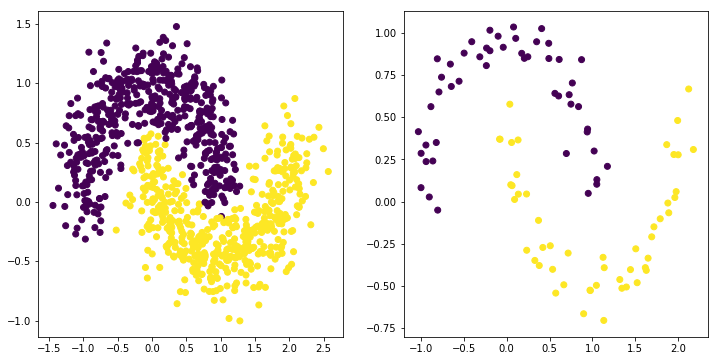

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X[:, 0], X[:, 1], c=np.where(a2[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))

## Ackely Investigation

In [5]:
%matplotlib inline

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def ackley(x, y):
    sum_sq_term = -20 * np.exp(-0.2*np.sqrt(0.5*(x*x+y*y)))
    cos_term = -np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y)))
    value = sum_sq_term+cos_term+np.exp(1)+20
    return value

class Ackley(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, coords):
        x = coords[:, 0]
        y = coords[:, 1]
        sum_sq_term = -20 * torch.exp(-0.2*torch.sqrt(0.5*(x*x+y*y)))
        cos_term = -torch.exp(0.5*(torch.cos(2*np.pi*x)+torch.cos(2*np.pi*y)))
        value = sum_sq_term+cos_term+np.exp(1)+20
        return value

In [7]:
def optimize_ackley(method, lr, N_points=100):
    set_seed(42)
    ackley_torch = Ackley()

    attempts = []
    for j in range(N_points):
        coords = torch.randn(1, 2)*2
        coords.requires_grad = True
        if method == "SGD":
            optimizer = torch.optim.SGD([coords], lr=lr)
        elif method == "SGD+Momentum":
            optimizer =  torch.optim.SGD([coords], lr=lr, momentum=0.9)
        elif method == "RMSProp":
            optimizer = torch.optim.RMSprop([coords], lr=lr)
        elif method == "Adam":
            optimizer = torch.optim.Adam([coords], lr)  
        steps = [coords.detach().numpy().copy()]
        for i in range(50):
            optimizer.zero_grad()
            f = ackley_torch(coords)
            f.backward()
            optimizer.step()
            steps.append(coords.detach().numpy().copy())
        attempts.append(steps)
    return attempts

In [8]:
def plot_ackley_and_trajectories(ax, attempts, method, lr):
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    # Make data.
    x, y = np.meshgrid(x, y)
    z = ackley(x, y)

    # Plot the surface.
    surf = ax.contourf(x, y, z, np.linspace(0, 10, 100), cmap=cm.coolwarm)
    for a in attempts:
        steps_np = np.array(a)[:, 0, :]
        ax.plot(steps_np[:, 0], steps_np[:, 1], linewidth=2, c="black", linestyle="--", alpha=0.1)

    for a in attempts:
        steps_np = np.array(a)[:, 0, :]
        ax.scatter(steps_np[[0], 0], steps_np[[0], 1], marker="o", color="yellow", s=50, zorder=100)
        ax.scatter(steps_np[[-1], 0], steps_np[[-1], 1], marker="o", color="magenta", s=50, zorder=100)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method+" "+str(lr))
    return True

done with  SGD
done with  SGD+Momentum
done with  RMSProp
done with  Adam


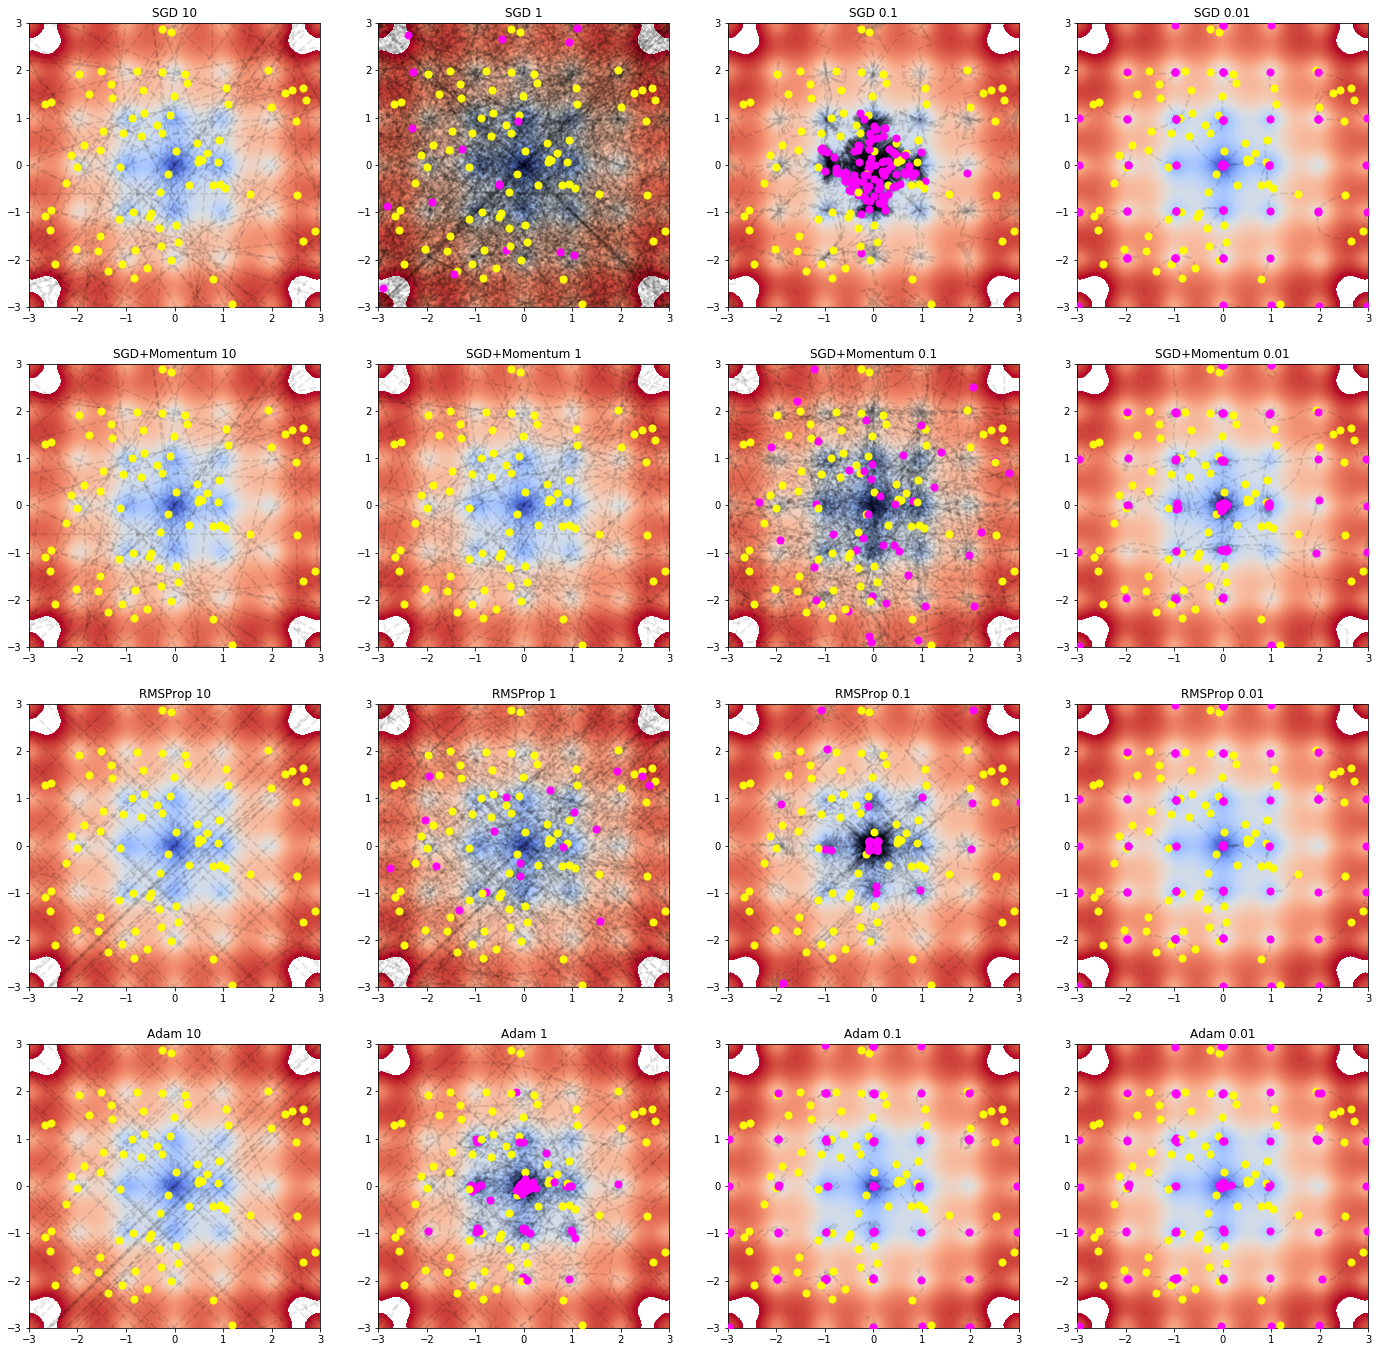

In [9]:
fig, axarr = plt.subplots(4, 4, figsize=(24, 24))
for ax_row, method in zip(axarr, ["SGD", "SGD+Momentum", "RMSProp", "Adam"]):
    for ax, lr in zip(ax_row, [10, 1, 1e-1, 1e-2]):
        attempts = optimize_ackley(method, lr)
        plot_ackley_and_trajectories(ax, attempts, method, lr)
    print("done with ", method)

Learning Rate 10: Trajectories diverge, no global minima found, no local minima found  
Learning Rate 1: Most Trajectories diverge, only Adam finds global and some local minima  
Learning Rate 1e-2: SGD finds points clode to global minimum, SGD+Momentum overshoots, Adam finds all local minima  
Learning Rate 1e-3: All learning methods dive into local minima, SGD+momentum and Adam have longer trajectories and find global minimum more often.  


## Improving the two-moons neural network

In [10]:
from torch.utils.data import TensorDataset, DataLoader 

class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H, bias=True)
        self.output = nn.Linear(H, O, bias=True)
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        z1 = self.hidden_1(X)
        a1 = self.activation(z1)
        z2 = self.output(a1)
        a2 = self.activation(z2)
        return a2

def bce_loss(y, a2):
    return -1/y.size(0)*(y*a2.log()+(1-y)*(1-a2).log()).sum(0)

def train(model, optimizer, data_loader):
    model.train()
    for X, y in data_loader:
        optimizer.zero_grad()
        a2 = model(X)
        loss = bce_loss(y, a2)
        loss.backward()
        optimizer.step()
    
    y_pred = np.where(a2[:, 0].detach().numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy

def evaluate(model, data_loader):
    model.eval()
    for X, y in data_loader:
        with torch.no_grad():
            a2 = model(X)
            loss = bce_loss(y, a2)
    y_pred = np.where(a2[:, 0].numpy()>0.5, 1, 0)
    accuracy = accuracy_score(y, y_pred)
    return loss, accuracy
    
#Define the size of the input, hidden, and output layers
I, H, O = 2, 3, 1

#Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

#Define Train Set in Pytorch
X_train = torch.from_numpy(X_train).float()[0] #Convert to torch tensor, single batch
y_train = torch.from_numpy(y_train).float()[0] #Convert to torch tensor, single batch

train_dataset = TensorDataset(X_train, y_train)

#Define Test Set in Pytorch
X_test = torch.from_numpy(X_test).float() #Convert to torch tensor, already single batch
y_test = torch.from_numpy(y_test).float() #Convert to torch tensor, already single batch

test_dataset = TensorDataset(X_test, y_test)

#Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=X_test.size(0), shuffle=False)

network = SingleHiddenLayerNetwork(I, H, O)
optim = torch.optim.SGD(network.parameters(), lr=1, momentum=0.9)
for i in range(1000):
    train_loss, train_accuracy = train(network, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, test_loader)
    
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % train_accuracy)
        print("Test Loss in epoch "+str(i)+": %1.2f" % test_loss.item())
        print("Test accuracy in epoch "+str(i)+": %1.2f" % test_accuracy, "\n")
                
        

Training Loss in epoch 0: 0.73
Training accuracy in epoch 0: 0.50
Test Loss in epoch 0: 0.71
Test accuracy in epoch 0: 0.50 

Training Loss in epoch 100: 0.28
Training accuracy in epoch 100: 0.87
Test Loss in epoch 100: 0.27
Test accuracy in epoch 100: 0.89 

Training Loss in epoch 200: 0.09
Training accuracy in epoch 200: 0.97
Test Loss in epoch 200: 0.04
Test accuracy in epoch 200: 1.00 

Training Loss in epoch 300: 0.08
Training accuracy in epoch 300: 0.97
Test Loss in epoch 300: 0.02
Test accuracy in epoch 300: 1.00 

Training Loss in epoch 400: 0.07
Training accuracy in epoch 400: 0.98
Test Loss in epoch 400: 0.01
Test accuracy in epoch 400: 1.00 

Training Loss in epoch 500: 0.07
Training accuracy in epoch 500: 0.98
Test Loss in epoch 500: 0.01
Test accuracy in epoch 500: 1.00 

Training Loss in epoch 600: 0.07
Training accuracy in epoch 600: 0.98
Test Loss in epoch 600: 0.01
Test accuracy in epoch 600: 1.00 

Training Loss in epoch 700: 0.07
Training accuracy in epoch 700: 0.98


Test set accuracy:  1.0


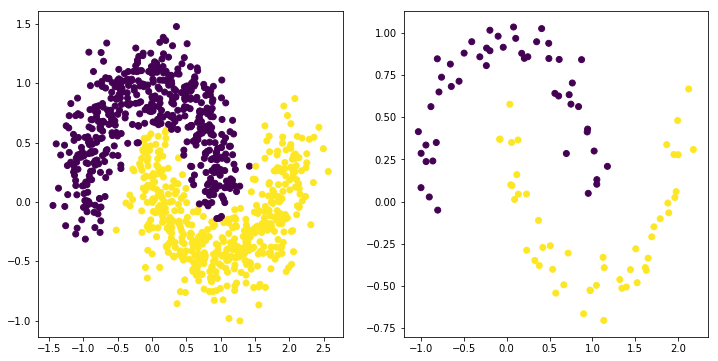

In [11]:
network.eval()
with torch.no_grad():
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))

Looks almost the same as our own backprop results!